In [1]:
%matplotlib inline

import glob
import itertools
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

# List of ImpactDAOs

In [2]:
dao_list = [
    "climatedao.eth", "klimadao.eth", "proteincommunity.eth", "primexyz.eth", 
    "earthfund.eth", "antidotedao.eth", "giv.eth", "gitcoindao.eth", "vote.vitadao.eth", 
    "bloomeria.eth", "kolektivo.eth", "devdao.eth", "thedreamdao.eth", "aeraforce.eth", 
    "opsci.eth", "cabindao.eth", "surgewomen.eth", "popcorn-snapshot.eth", "poh.eth", 
    "coherenetwork.eth", "artizenfund.eth", "labdao.eth", "voizdao-gov.eth", "kleros.eth", "nftreehaus.eth"
]
len(dao_list)

25

# Get proposals

In [3]:
def get_proposals(list_of_daos):

    str_list = ", ".join(f'"{x}"' for x in list_of_daos)
    query = """
        query Proposals {
            proposals(
              first: 1000,
              skip: 0,
              where: {
                space_in: [$DAO_LIST],
                state: "closed"
              },
              orderBy: "created",
              orderDirection: desc
            ) {
              id
              title
              body
              choices
              start
              end
              snapshot
              state
              scores
              scores_by_strategy
              scores_total
              scores_updated
              author      
              space {
                id
                name
              }
            }
          }
    """
    query = query.replace("$DAO_LIST", str_list)
    url = 'https://hub.snapshot.org/graphql/'
    
    r = requests.post(url, json={'query': query})
    json_data = json.loads(r.text)
    
    df = pd.DataFrame(json_data['data']['proposals'])
    df['dao_ens'] = df['space'].apply(lambda x: x['id'])
    df['dao'] = df['space'].apply(lambda x: x['name'])
    df.drop(columns='space', inplace=True)
    
    return df

In [4]:
proposals_df = get_proposals(dao_list)
print(len(proposals_df))
proposals_df.head()

397


,id,title,body,choices,start,end,snapshot,state,scores,scores_by_strategy,scores_total,scores_updated,author,dao_ens,dao
0,0x83a75014f3bad0af0cd2ff304cac2c293d36665acfd7...,Gatherings WG Coordinator Election,These are the candidates running to coordinate...,"[Aishah Binte Syamsul Bahri, Joshua Santiago C...",1655521200,1655780400,14981493,closed,"[12, 12, 0]","[[12], [12], [0]]",24.0,1655780434,0x5AbF453683da9bA4E4E3Cdd4a50f4759C670FB51,thedreamdao.eth,Dream DAO
1,0x30bcb1d7d6f7709adb2ad1e8d58872554684450516fe...,Dream DAO PROPOSAL #39: Assign Ethan Wei as th...,Ethan Wei (ethandub#0808) was the only person ...,"[For, Against, Abstain]",1655505435,1655764635,14981640,closed,"[23, 0, 0]","[[23], [0], [0]]",23.0,1655764652,0x5AbF453683da9bA4E4E3Cdd4a50f4759C670FB51,thedreamdao.eth,Dream DAO
2,0x661cbb17f0ae67afdd8d76511aecee50f05001368af4...,NEAR Education Group WG Coordinator Election,These are the candidates running to coordinate...,"[Madhav Goyal, Adarsh Choudhary]",1655503200,1655762400,14981517,closed,"[19, 4]","[[19], [4]]",23.0,1655762432,0x5AbF453683da9bA4E4E3Cdd4a50f4759C670FB51,thedreamdao.eth,Dream DAO
3,0x4763c48ab73e1f577e889c846ace169b5751f2bc739a...,Governance WG Coordinator Election,These are the candidates running to coordinate...,"[Ash Kranti Srivastava, Timofei Dort-Golts (Tim)]",1655503200,1655762400,14981507,closed,"[10, 15]","[[10], [15]]",25.0,1655762432,0x5AbF453683da9bA4E4E3Cdd4a50f4759C670FB51,thedreamdao.eth,Dream DAO
4,0xdb6468444192e803b14aea86694418ca2b3c14ce9cf2...,Community Building WG Coordinator Election,These are the candidates running to coordinate...,"[Arath Velasco, Oliver Yehlik, Arman (Karl) Si...",1655503200,1655762400,14981469,closed,"[15, 0, 14]","[[15], [0], [14]]",29.0,1655762433,0x5AbF453683da9bA4E4E3Cdd4a50f4759C670FB51,thedreamdao.eth,Dream DAO


In [6]:
proposals_df['dao'].value_counts()

Proof Of Humanity    68
Gitcoin              63
PrimeDAO             50
Dream DAO            43
Cabin                38
VitaDAO              35
Klima DAO            26
Kleros               17
Developer DAO        12
Popcorn              10
Protein Community     9
Giveth                9
VoizDAO               7
EarthFund             2
Bloomeria             2
Kolektivo             2
Surge Women           1
NFTree Haus           1
Aera Force            1
AntidoteDAO           1
Name: dao, dtype: int64

# Get votes

In [7]:
JSON_DATAPATH = 'votes/voting_records.json'

def get_votes(proposal_id):

    query = """
         query Votes {
      votes (
        first: 3000
        where: {
          proposal: "$PROPOSAL"
        }
      ) {
        id
        voter
        vp
        created
        choice
        space {
          id
        }
      }
    }
    """
    query = query.replace("$PROPOSAL", proposal_id)
    url = 'https://hub.snapshot.org/graphql/'
    
    r = requests.post(url, json={'query': query})
    json_data = json.loads(r.text)
    return json_data
    
def update_voting_records(proposal_id):
    
    if not glob.glob(JSON_DATAPATH):
        f = open(JSON_DATAPATH, "w") 
        f.close() 

    with open(JSON_DATAPATH, 'r+') as json_file:
        try:
            data = json.load(json_file)
        except:
            data = []
        if data:
            if proposal_id in [record['proposal'] for record in data]:
                return None
            
        json_data = get_votes(proposal_id)
        data.append({
            'proposal': proposal_id, 
            'votes': json_data['data']['votes']
        })
        json_file.seek(0)
        json.dump(data, json_file, indent=4)
    
    print("Success:", proposal_id)

In [8]:
for p in proposals_df['id']:
    update_voting_records(p)

In [9]:
records = []
with open(JSON_DATAPATH, 'r+') as json_file:
    data = json.load(json_file)
    for proposal in data:
        votes = proposal['votes']
        for v in votes:
            records.append({
                'proposal': proposal['proposal'],
                'voter': v['voter'],
                'vp': v['vp'],
                'choice': str(v['choice']),
                'dao': v['space']['id']
            })
df = pd.DataFrame.from_records(records)
len(df)

75077

In [10]:
df['voter'].value_counts()

0xE7CF8Fce5e83e07e56E2EBfEb7651f459c47217b    73
0x06c4865ab16c9C760622f19a313a2E637E2e66a2    71
0x0B1f8Ee2f813f06aC5fb8aad74AaCB71fb2f51FA    64
0x2FC3Fd7c06aDfc48736122ea33820038CC16DcDb    60
0x4131826eaFDCb7dcd855Fae9098EC693165F157d    60
                                              ..
0xb101D6D62C1C4f803eE8472Cd17FA26C8DE1a7C8     1
0x48b8d30c4EEdA5716A047b817De01f158bE4CF8b     1
0x1594B51f65Ff2BE33E586B94083309a7E5Ea22E6     1
0x12BC835C18C6Bb63b82bE4fEDa04971cf0c5A8F5     1
0xC2e02535829667715E089C7c4dec3BdCB5c484F5     1
Name: voter, Length: 15114, dtype: int64

# Analysis on voter trends

Text(0, 0.5, '# Wallet Addresses')

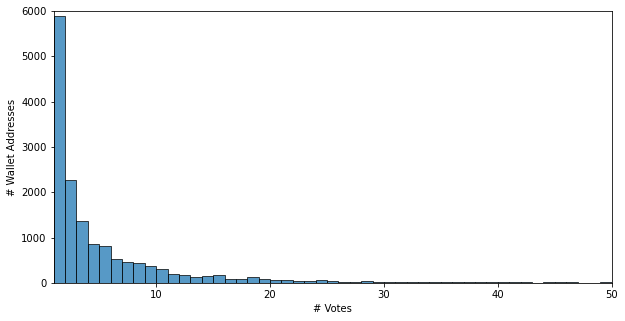

In [11]:
fig, ax = plt.subplots(figsize=(10,5))

voter_counts = df['voter'].value_counts()
voter_counts.name = "# Votes"
sns.histplot(voter_counts, binwidth=1, ax=ax)
ax.set_xlim(1,50)
ax.set_ylim(0,6000)
ax.set_ylabel('# Wallet Addresses')

Text(0, 0.5, '# Wallet Addresses')

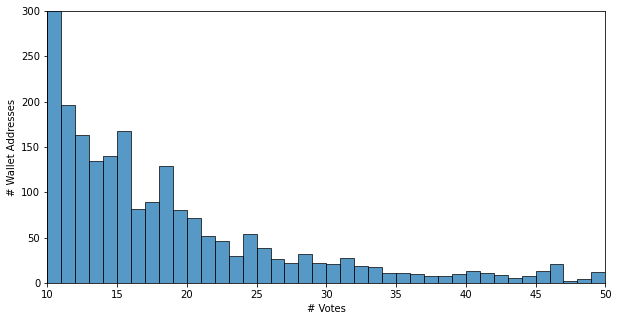

In [12]:
fig, ax = plt.subplots(figsize=(10,5))

voter_counts = df['voter'].value_counts()
voter_counts.name = "# Votes"
sns.histplot(voter_counts, binwidth=1, ax=ax)
ax.set_xlim(10,50)
ax.set_ylim(0,300)
ax.set_ylabel('# Wallet Addresses')

# DAO connections

In [13]:
dao_connections = pd.crosstab(df['voter'], df['dao'])
daoers = dao_connections.apply(lambda x: x>0).sum(axis=1)
wallet_order = daoers.sort_values(ascending=False).index
dao_connections = dao_connections.reindex(wallet_order)
wallets = (dao_connections.apply(lambda x: x>0).sum(axis=1) > 1)
dao_connections = dao_connections[wallets]

cols = [c for c, x in dao_connections.sum(axis=0).sort_values(ascending=False).items() if x>1] 
dao_connections = dao_connections[cols]
len(dao_connections)

448

In [14]:
connections = []
for voter, row in dao_connections.iterrows():
    dao_list = [dao for dao, count in row.items() if count > 0]        
    connections.extend(list(itertools.combinations(dao_list,2)))    

In [15]:
pd.DataFrame(connections, columns=['source', 'target']).to_csv("links.csv")

In [16]:
dao_connections.apply(lambda x: x>0).sum(axis=0).to_csv("edges.csv")

[]

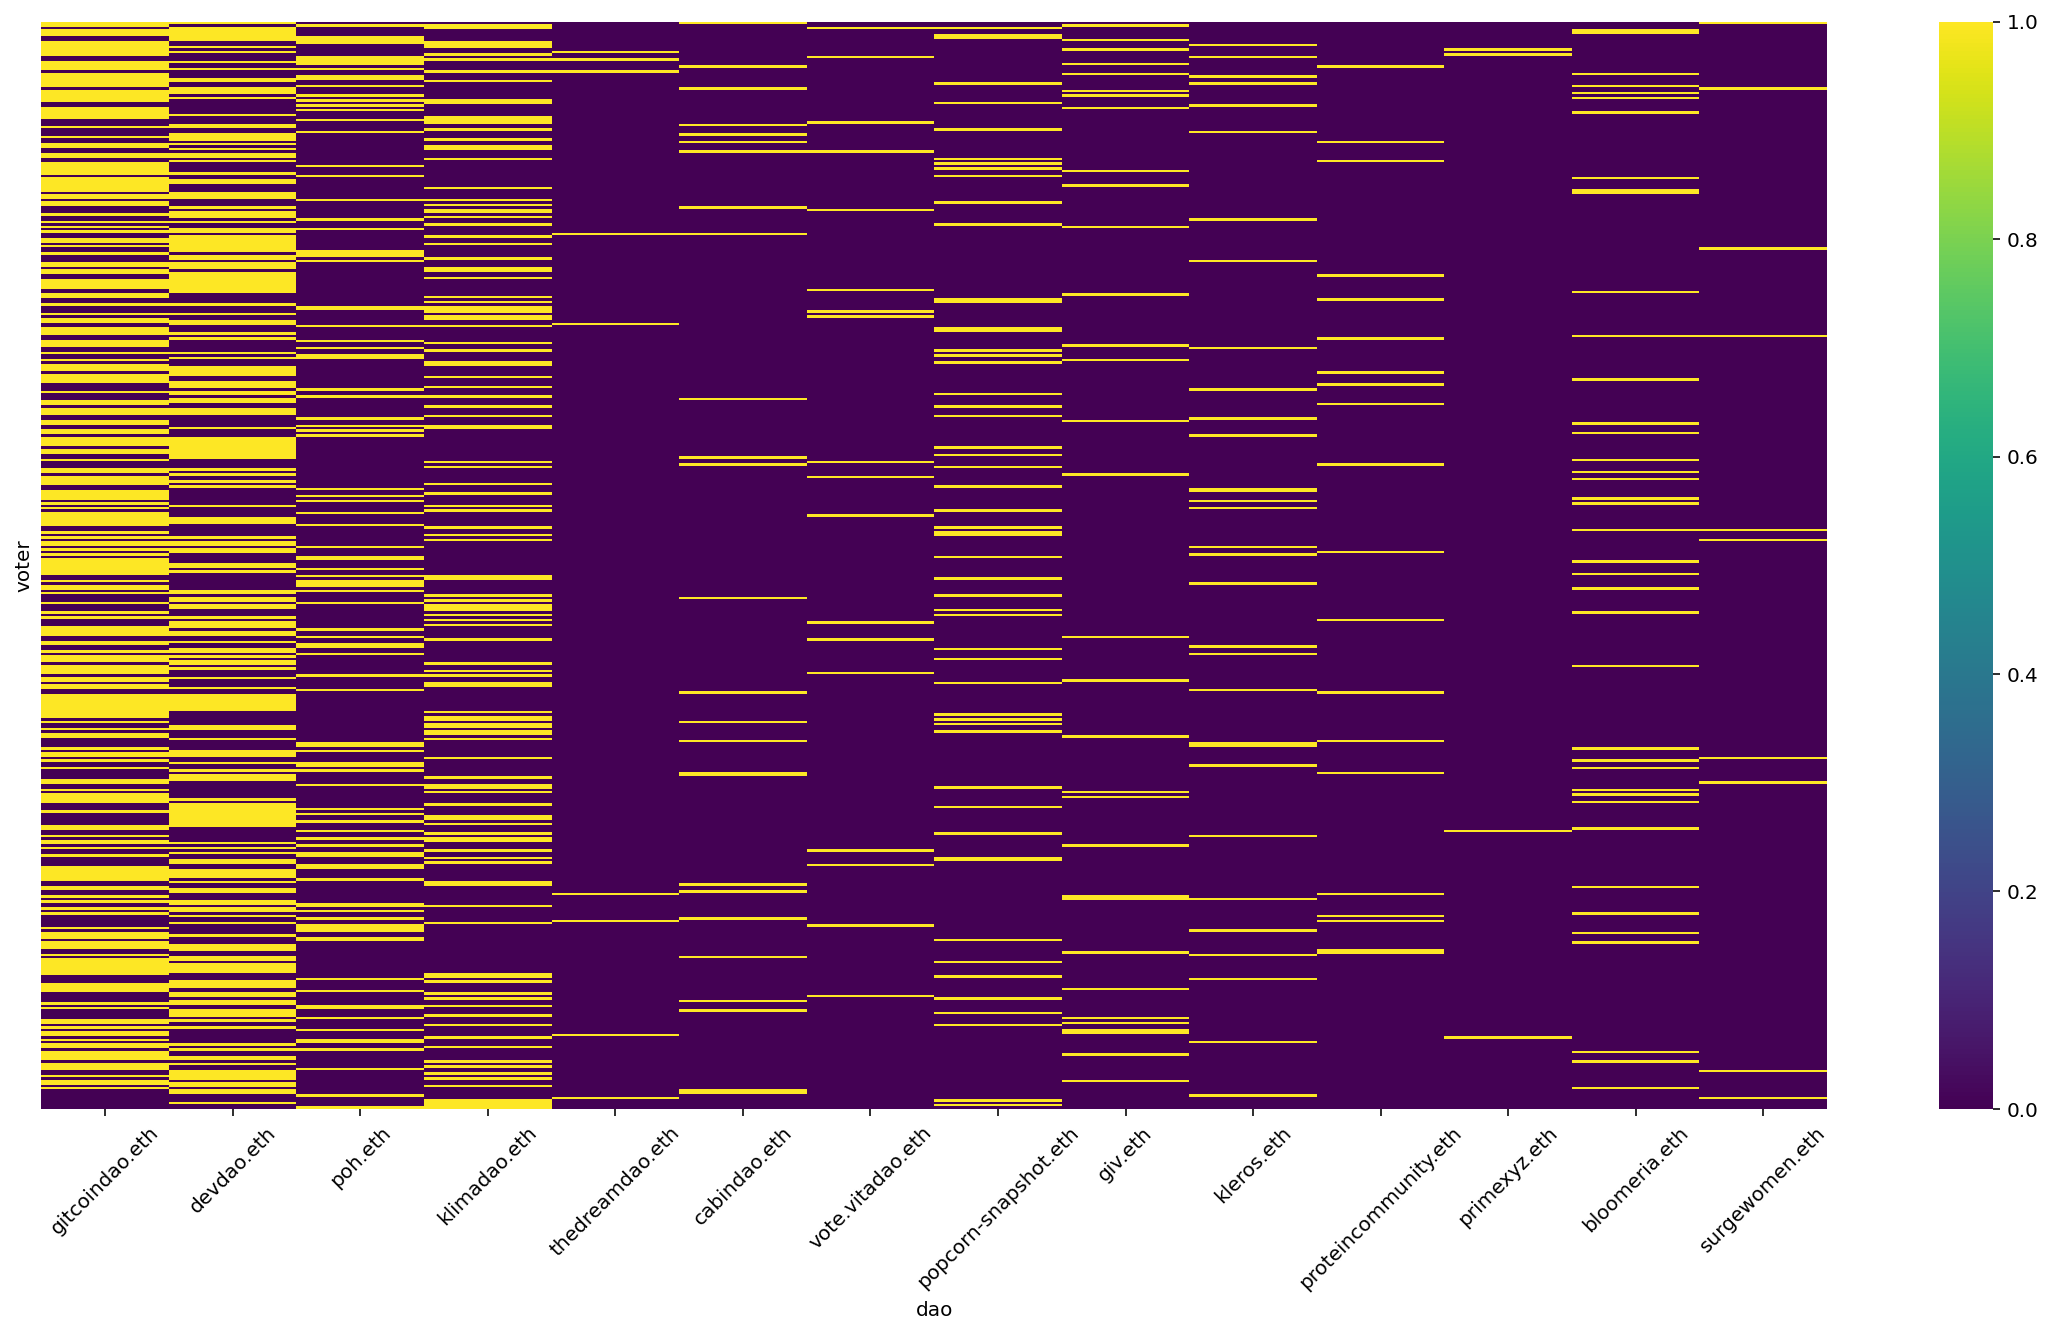

In [17]:
fig, ax = plt.subplots(figsize=(20,10), facecolor='white', dpi=144)
sns.heatmap(
    dao_connections, 
    cmap='viridis',
    ax=ax,
    vmax=1,
    #linecolor='black',
    #linewidths=.01
)
plt.xticks(rotation=45)
ax.set_yticks([])